In [1]:
# Bibliotecas generales
import pandas as pd
import numpy as np
import re
import itertools

# Bibliotecas de interfaz gráfica
import tkinter as tk
from tkinter import filedialog, messagebox

# Bibliotecas de visualización
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Bibliotecas de procesamiento de lenguaje natural (NLP)
import nltk
from nltk.stem import PorterStemmer
from nltk import FreqDist

# Bibliotecas de PySpark
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StandardScaler,
    StringIndexer,
    OneHotEncoder,
    VectorAssembler,
    Interaction,
    StopWordsRemover,
    CountVectorizer,
    Tokenizer,
    CountVectorizerModel,
)
from pyspark.ml.linalg import Vectors, DenseVector, SparseVector, VectorUDT
from pyspark.sql.functions import col, when, lower, regexp_replace, split, concat_ws, monotonically_increasing_id, expr
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.functions import pandas_udf, udf
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics


In [2]:
# Inicializa la biblioteca NLTK y el stemmer
nltk.download('punkt')  # Descargar el tokenizer si aún no lo tienes

[nltk_data] Downloading package punkt to /home/adair/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Initialize Spark
spark = SparkSession.builder.appName("Regression").getOrCreate()

23/09/28 23:33:49 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [4]:
path = './spam.csv'
df = spark.read.csv(path, header = True, inferSchema=True)
df = df.drop('_c2', '_c3', '_c4')
df.show()

+----+--------------------+
|  v1|                  v2|
+----+--------------------+
| ham|Go until jurong p...|
| ham|Ok lar... Joking ...|
|spam|Free entry in 2 a...|
| ham|U dun say so earl...|
| ham|Nah I don't think...|
|spam|FreeMsg Hey there...|
| ham|Even my brother i...|
| ham|As per your reque...|
|spam|WINNER!! As a val...|
|spam|Had your mobile 1...|
| ham|I'm gonna be home...|
|spam|SIX chances to wi...|
|spam|URGENT! You have ...|
| ham|I've been searchi...|
| ham|I HAVE A DATE ON ...|
|spam|XXXMobileMovieClu...|
| ham|Oh k...i'm watchi...|
| ham|Eh u remember how...|
| ham|Fine if thatåÕs t...|
|spam|England v Macedon...|
+----+--------------------+
only showing top 20 rows



In [5]:
df.groupBy("v1").count().show()

+----+-----+
|  v1|count|
+----+-----+
| ham| 4827|
|spam|  747|
+----+-----+



In [6]:
df.describe().show()

+-------+----+--------------------+
|summary|  v1|                  v2|
+-------+----+--------------------+
|  count|5574|                5574|
|   mean|null|               645.0|
| stddev|null|                null|
|    min| ham| &lt;#&gt;  in mc...|
|    max|spam|ÌÏ wait 4 me in s...|
+-------+----+--------------------+



In [7]:
# Convierte la columna "type" en un índice numérico
indexer = StringIndexer(inputCol="v1", outputCol="type")
df = indexer.fit(df).transform(df)
df = df.drop('v1')
df.show()

+--------------------+----+
|                  v2|type|
+--------------------+----+
|Go until jurong p...| 0.0|
|Ok lar... Joking ...| 0.0|
|Free entry in 2 a...| 1.0|
|U dun say so earl...| 0.0|
|Nah I don't think...| 0.0|
|FreeMsg Hey there...| 1.0|
|Even my brother i...| 0.0|
|As per your reque...| 0.0|
|WINNER!! As a val...| 1.0|
|Had your mobile 1...| 1.0|
|I'm gonna be home...| 0.0|
|SIX chances to wi...| 1.0|
|URGENT! You have ...| 1.0|
|I've been searchi...| 0.0|
|I HAVE A DATE ON ...| 0.0|
|XXXMobileMovieClu...| 1.0|
|Oh k...i'm watchi...| 0.0|
|Eh u remember how...| 0.0|
|Fine if thatåÕs t...| 0.0|
|England v Macedon...| 1.0|
+--------------------+----+
only showing top 20 rows



In [8]:
# Mostrar el tipo de datos de la columna "type"
df.select("type").printSchema()
# Calcular la tabla de frecuencia de los valores en la columna "type"
df.groupBy("type").count().show()

root
 |-- type: double (nullable = false)

+----+-----+
|type|count|
+----+-----+
| 0.0| 4827|
| 1.0|  747|
+----+-----+



In [9]:
# Selecciona la columna "text" del DataFrame
text_column = df.select("v2","type")

In [10]:
text_column.show()

+--------------------+----+
|                  v2|type|
+--------------------+----+
|Go until jurong p...| 0.0|
|Ok lar... Joking ...| 0.0|
|Free entry in 2 a...| 1.0|
|U dun say so earl...| 0.0|
|Nah I don't think...| 0.0|
|FreeMsg Hey there...| 1.0|
|Even my brother i...| 0.0|
|As per your reque...| 0.0|
|WINNER!! As a val...| 1.0|
|Had your mobile 1...| 1.0|
|I'm gonna be home...| 0.0|
|SIX chances to wi...| 1.0|
|URGENT! You have ...| 1.0|
|I've been searchi...| 0.0|
|I HAVE A DATE ON ...| 0.0|
|XXXMobileMovieClu...| 1.0|
|Oh k...i'm watchi...| 0.0|
|Eh u remember how...| 0.0|
|Fine if thatåÕs t...| 0.0|
|England v Macedon...| 1.0|
+--------------------+----+
only showing top 20 rows



In [11]:
# Utilizando la función lower
text_column = text_column.withColumn("v2", lower(col("v2")))

In [12]:
# Definir una función personalizada para eliminar números
def remove_numbers(text):
    return regexp_replace(text, r'\d+', '')  # Esto reemplaza los números con una cadena vacía

# Aplicar la función a la columna "text"
text_column = text_column.withColumn("v2", remove_numbers(col("v2")))

In [13]:
# Divide la columna "text" en palabras
text_column = text_column.withColumn("text_words", split(col("v2"), " "))

# Crea un objeto StopWordsRemover con las stopwords en inglés predefinidas
remover = StopWordsRemover(inputCol="text_words", outputCol="filtered_text")

# Aplica el remover al DataFrame
text_column = remover.transform(text_column)

# Utiliza concat_ws para unir las palabras en una sola cadena, separadas por un espacio en blanco
text_column = text_column.withColumn("v2", concat_ws(" ", col("filtered_text")))

In [14]:
text_column.select('v2').collect()[6][0]

'even brother like speak me. treat like aids patent.'

In [15]:
# Utiliza regexp_replace para eliminar la puntuación
text_column = text_column.withColumn("v2", regexp_replace(col("v2"), r'[^\w\s]', ' '))

In [16]:
text_column.select('v2').collect()[2][0]

'free entry  wkly comp win fa cup final tkts st may   text fa  receive entry question std txt rate t c s apply over s'

In [17]:
stemmer = PorterStemmer()

# Crear una función UDF para aplicar el stemming a cada palabra
def stem_text(text):
    words = nltk.word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

# Registra la función UDF
stem_text_udf = udf(stem_text, StringType())

# Aplica el UDF al DataFrame
text_column = text_column.withColumn("stemmed_text", stem_text_udf(col("v2")))

In [18]:
cleaned_text = text_column.select('stemmed_text', 'type')

In [19]:
# Dividir el texto en palabras (tokenización)
tokenizer = Tokenizer(inputCol="stemmed_text", outputCol="words")
words_data = tokenizer.transform(cleaned_text)

# Configura el CountVectorizer
count_vectorizer = CountVectorizer(inputCol="words", outputCol="features")

# Crea un pipeline para realizar la tokenización y el conteo de términos
pipeline = Pipeline(stages=[tokenizer, count_vectorizer])

# Elimina la columna "words" si ya existe en el DataFrame
if "words" in words_data.columns:
    words_data = words_data.drop("words")

# Ajusta el pipeline al DataFrame
model = pipeline.fit(words_data)

# Transforma el DataFrame en una matriz término-documento
sms_dtm = model.transform(words_data)
final_df = sms_dtm.select('features', 'type', 'stemmed_text', 'words')

In [20]:
# Muestra el resultado
sms_dtm.show()

+--------------------+----+--------------------+--------------------+
|        stemmed_text|type|               words|            features|
+--------------------+----+--------------------+--------------------+
|go jurong point c...| 0.0|[go, jurong, poin...|(6388,[2,17,44,76...|
|ok lar joke wif u...| 0.0|[ok, lar, joke, w...|(6388,[0,8,278,40...|
|free entri wkli c...| 1.0|[free, entri, wkl...|(6388,[10,12,21,2...|
|u dun say earli h...| 0.0|[u, dun, say, ear...|(6388,[0,54,68,10...|
|nah think goe usf...| 0.0|[nah, think, goe,...|(6388,[35,163,182...|
|freemsg hey darl ...| 1.0|[freemsg, hey, da...|(6388,[8,12,14,22...|
|even brother like...| 0.0|[even, brother, l...|(6388,[14,23,100,...|
|per request mell ...| 0.0|[per, request, me...|(6388,[87,174,416...|
|winner valu netwo...| 1.0|[winner, valu, ne...|(6388,[1,78,96,15...|
|mobil month more ...| 1.0|[mobil, month, mo...|(6388,[0,1,10,37,...|
|gon na home soon ...| 0.0|[gon, na, home, s...|(6388,[18,29,34,4...|
|six chanc win cas..

In [21]:
# Divide los datos en conjuntos de entrenamiento y prueba
train_data, test_data = final_df.randomSplit([0.75, 0.25], seed=123)

# Muestra el número de filas en cada conjunto
print("Número de filas en el conjunto de entrenamiento: {}".format(train_data.count()))
print("Número de filas en el conjunto de prueba: {}".format(test_data.count()))

Número de filas en el conjunto de entrenamiento: 4165


Número de filas en el conjunto de prueba: 1409


In [22]:
# Realiza un conteo de las categorías
category_counts_train = train_data.groupBy("type").count()
# Calcula la proporción de frecuencia relativa
category_counts_train = category_counts_train.withColumn("relative_frequency", col("count") / train_data.count())
# Realiza un conteo de las categorías
category_counts_test = test_data.groupBy("type").count()
# Calcula la proporción de frecuencia relativa
category_counts_test = category_counts_test.withColumn("relative_frequency", col("count") / test_data.count())
category_counts_train.show()
category_counts_test.show()

+----+-----+-------------------+
|type|count| relative_frequency|
+----+-----+-------------------+
| 0.0| 3593| 0.8626650660264106|
| 1.0|  572|0.13733493397358942|
+----+-----+-------------------+



+----+-----+------------------+
|type|count|relative_frequency|
+----+-----+------------------+
| 0.0| 1234|0.8757984386089425|
| 1.0|  175|0.1242015613910575|
+----+-----+------------------+



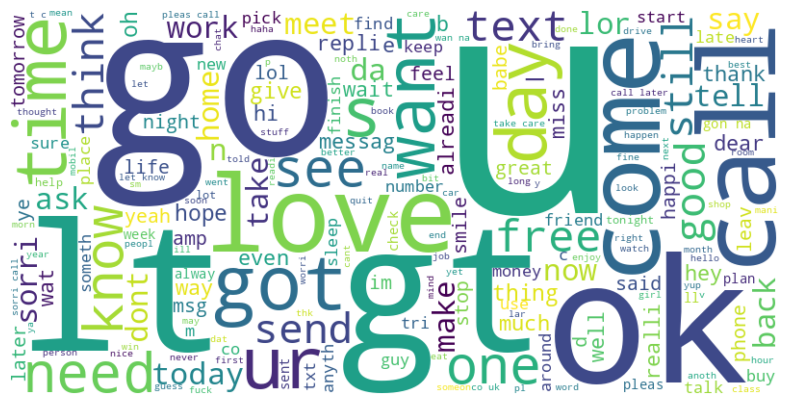

In [23]:
# Unir todas las filas de "stemmed_text" en un solo string
text = " ".join(final_df.select("stemmed_text").rdd.flatMap(lambda x: x).collect())

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42)
wordcloud.generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

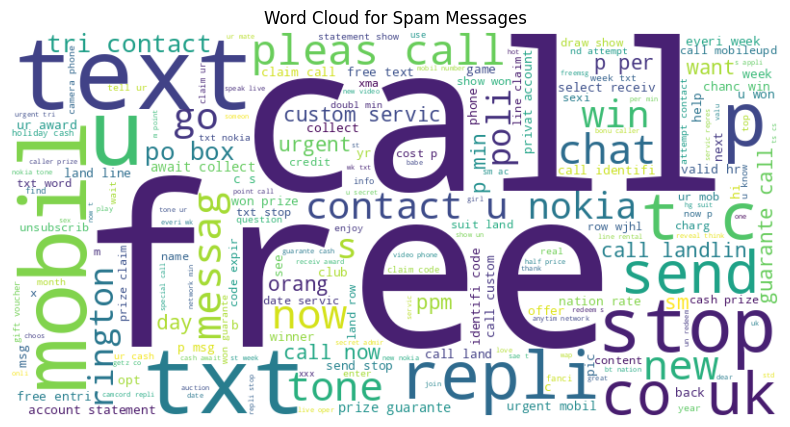

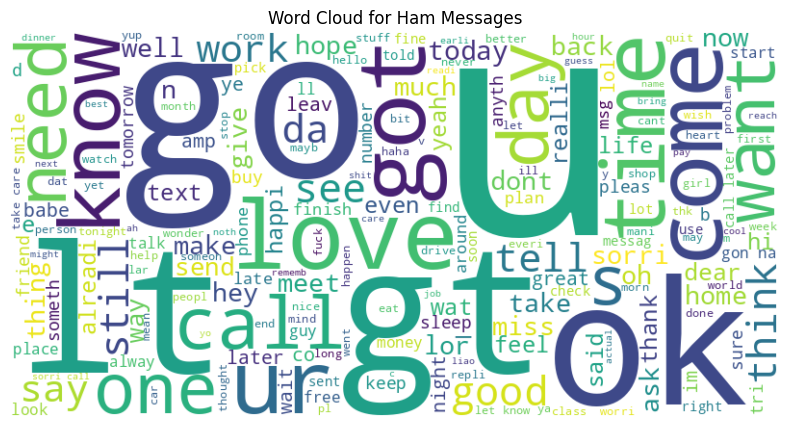

In [24]:
# Filtrar el DataFrame 'final_df' para obtener los mensajes marcados como "spam"
spam_df = final_df.filter(final_df.type == 1.0)

# Filtrar el DataFrame 'final_df' para obtener los mensajes marcados como "ham" (no spam)
ham_df = final_df.filter(final_df.type == 0.0)

# Función para generar y mostrar nubes de palabras
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42)
    wordcloud.generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

# Crear una nube de palabras para los mensajes "spam"
spam_text = " ".join(spam_df.select("stemmed_text").rdd.flatMap(lambda x: x).collect())
generate_wordcloud(spam_text, "Word Cloud for Spam Messages")

# Crear una nube de palabras para los mensajes "ham"
ham_text = " ".join(ham_df.select("stemmed_text").rdd.flatMap(lambda x: x).collect())
generate_wordcloud(ham_text, "Word Cloud for Ham Messages")

In [25]:
# Configura el CountVectorizer
count_vectorizer = CountVectorizer(inputCol="words", outputCol="features2", minDF=5)

# Crea un pipeline para ajustar el CountVectorizer al conjunto de entrenamiento
pipeline = Pipeline(stages=[count_vectorizer])

# Ajusta el pipeline al conjunto de entrenamiento
model = pipeline.fit(train_data)

# Obtén el modelo del CountVectorizer
count_vectorizer_model = model.stages[0]

# Obten las palabras más frecuentes
sms_freq_words = count_vectorizer_model.vocabulary

In [26]:
# Define una función de usuario (UDF) para modificar los valores en la segunda lista del SparseVector
def modificar_sparse_vector(features):
    # Extrae los índices y los valores del SparseVector
    indices = features.indices
    valores = features.values

    # Modifica los valores en la segunda lista (índices 1)
    valores_modificados = [1 if valor > 0.0 else 0 for valor in valores]

    # Crea un nuevo SparseVector con los valores modificados
    nuevo_sparse_vector = SparseVector(len(features), indices, valores_modificados)

    return nuevo_sparse_vector

# Registra la UDF y aplica la transformación
modificar_vector_udf = udf(modificar_sparse_vector, VectorUDT())
train_data = train_data.withColumn("features_modificados", modificar_vector_udf("features"))
test_data = test_data.withColumn("features_modificados", modificar_vector_udf("features"))


# Muestra el DataFrame resultante
train_data.select("features_modificados").show()

+--------------------+
|features_modificados|
+--------------------+
|    (6388,[0],[1.0])|
|    (6388,[0],[1.0])|
|(6388,[0,1,2,7,23...|
|(6388,[0,1,2,7,34...|
|(6388,[0,1,2,10,1...|
|(6388,[0,1,2,28,4...|
|(6388,[0,1,2,29,3...|
|(6388,[0,1,2,38,8...|
|(6388,[0,1,2,45,5...|
|(6388,[0,1,3,4,9,...|
|(6388,[0,1,3,16,1...|
|(6388,[0,1,3,16,5...|
|(6388,[0,1,4,9,19...|
|(6388,[0,1,4,9,36...|
|(6388,[0,1,4,32,3...|
|(6388,[0,1,4,35,3...|
|(6388,[0,1,4,35,3...|
|(6388,[0,1,4,35,3...|
|(6388,[0,1,4,35,3...|
|(6388,[0,1,4,35,3...|
+--------------------+
only showing top 20 rows



In [27]:
naive_bayes = NaiveBayes(smoothing=1.0,modelType="multinomial", labelCol="type", featuresCol="features_modificados")
pipeline_nb = Pipeline(stages=[naive_bayes])
model_nb = pipeline_nb.fit(train_data)
predictions = model_nb.transform(test_data)

In [28]:
train_data.show()

+--------------------+----+--------------------+--------------------+--------------------+
|            features|type|        stemmed_text|               words|features_modificados|
+--------------------+----+--------------------+--------------------+--------------------+
|    (6388,[0],[1.0])| 0.0|                   u|                 [u]|    (6388,[0],[1.0])|
|    (6388,[0],[1.0])| 0.0|                   u|                 [u]|    (6388,[0],[1.0])|
|(6388,[0,1,2,7,23...| 0.0|tomorrow go theat...|[tomorrow, go, th...|(6388,[0,1,2,7,23...|
|(6388,[0,1,2,7,34...| 0.0|dunno dad said co...|[dunno, dad, said...|(6388,[0,1,2,7,34...|
|(6388,[0,1,2,10,1...| 0.0|hmmm thk sure got...|[hmmm, thk, sure,...|(6388,[0,1,2,10,1...|
|(6388,[0,1,2,28,4...| 0.0|hi darlin kate u ...|[hi, darlin, kate...|(6388,[0,1,2,28,4...|
|(6388,[0,1,2,29,3...| 0.0|noth ju tot u ask...|[noth, ju, tot, u...|(6388,[0,1,2,29,3...|
|(6388,[0,1,2,38,8...| 0.0|oh thkin goin yog...|[oh, thkin, goin,...|(6388,[0,1,2,38,8...|

In [29]:
test_data.show()

+--------------------+----+--------------------+--------------------+--------------------+
|            features|type|        stemmed_text|               words|features_modificados|
+--------------------+----+--------------------+--------------------+--------------------+
|(6388,[0,1,2,7,23...| 0.0|tomorrow go theat...|[tomorrow, go, th...|(6388,[0,1,2,7,23...|
|(6388,[0,1,2,19,7...| 0.0|oh that late well...|[oh, that, late, ...|(6388,[0,1,2,19,7...|
|(6388,[0,1,3,13,2...| 0.0|turn phone mom te...|[turn, phone, mom...|(6388,[0,1,3,13,2...|
|(6388,[0,1,3,15,5...| 1.0|u get phone now w...|[u, get, phone, n...|(6388,[0,1,3,15,5...|
|(6388,[0,1,4,10,3...| 1.0|won guarante awar...|[won, guarante, a...|(6388,[0,1,4,10,3...|
|(6388,[0,1,4,35,3...| 1.0|u secret admir lo...|[u, secret, admir...|(6388,[0,1,4,35,3...|
|(6388,[0,1,4,42,4...| 1.0|call tell u call ...|[call, tell, u, c...|(6388,[0,1,4,42,4...|
|(6388,[0,1,5,6,24...| 0.0|solv d case man f...|[solv, d, case, m...|(6388,[0,1,5,6,24...|

In [30]:
# Inicializa un evaluador para calcular la precisión (puedes cambiar la métrica según tus necesidades)
evaluator = MulticlassClassificationEvaluator(labelCol="type", predictionCol="prediction", metricName="accuracy")

# Calcula la métrica de evaluación (en este caso, precisión)
accuracy = evaluator.evaluate(predictions)

# Muestra el resultado
print(f"Accuracy: {accuracy}")


23/09/28 23:36:19 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Accuracy: 0.9758694109297374


/opt/spark-3.4.1-bin-hadoop3/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
DenseMatrix([[1215.,   19.],
             [  15.,  160.]])


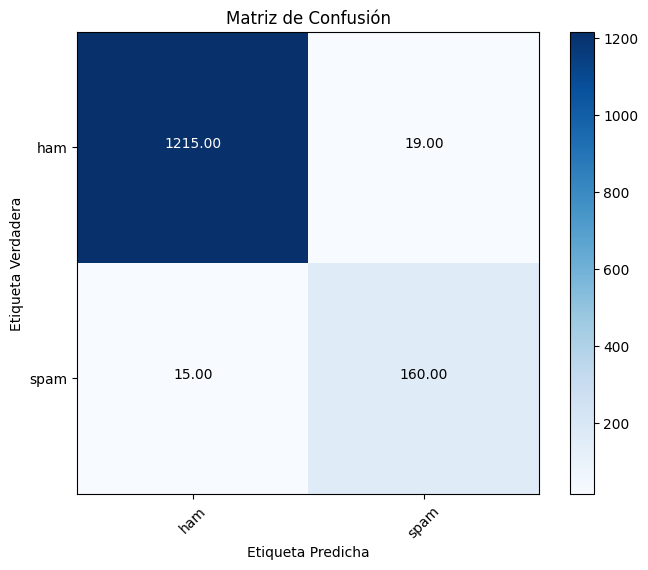

In [31]:
# Convierte el DataFrame de PySpark en un RDD de etiquetas reales y predichas
prediction_and_label = predictions.select("prediction", "type").rdd

# Inicializa un objeto MulticlassMetrics
metrics = MulticlassMetrics(prediction_and_label)

# Obtiene la matriz de confusión
confusion_matrix = metrics.confusionMatrix()

# Muestra la matriz de confusión
print("Confusion Matrix:")
print(confusion_matrix)

# Convierte la matriz de confusión en un formato adecuado para graficar
confusion_matrix = confusion_matrix.toArray()
classes = ["ham", "spam"]  # Reemplaza con tus nombres de clases reales

# Grafica la matriz de confusión
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = confusion_matrix.max() / 2.0
for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
    plt.text(j, i, format(confusion_matrix[i, j], '.2f'), horizontalalignment="center", color="white" if confusion_matrix[i, j] > thresh else "black")

plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.show()